## This is an algorithm development playground for UBS Quant contest

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Concatenate
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_update_rate(df, n=5):
    update_rate = []
    for i in range(len(df.columns)):
        counter_start = 0
        min_counter = len(df) + 1
        for j in range(n): # go for n loops to verify the update rate
            counter = 0
            start = df.iloc[counter_start, i]
            while True:
                counter += 1
                if not start == df.iloc[counter_start+counter, i]:
                    break
            counter_start = counter + counter_start
            if counter < min_counter:
                min_counter = counter
            if counter_start >= len(df):
                break
        update_rate.append(min_counter)
    return update_rate

In [3]:
def windowed_return_rate(df, window_size=14, thresh=0.005):
    """
    use the mean of this window_size, and previous window_size to calcualte a stablized return rate
    
    the start_index is window_size
    """
    out = df.copy()
    
    counter = window_size
    for i in range(window_size, len(df)-window_size):
        prev_mean = df.iloc[i-window_size:i, :].mean()
        cur_mean = df.iloc[i:i+window_size, :].mean()
        cur_row = (cur_mean - prev_mean) / prev_mean
        
        if not (cur_row <= 2).all() or not (cur_row > -0.8).all(): # use the most recent good row as cur row, if bad data
            cur_row = good_row
        else: # update good row if not bad data
            good_row = cur_row
            
        # updata data
        out.iloc[counter, :] = cur_row
        
        # updata counter
        counter += 1
        
    # discretize data
    out[out > thresh] = 2
    out[abs(out) <= thresh] = 1
    out[out < -thresh] = 0
    
    return out.iloc[window_size:counter, :]

def moving_average(df, window_size=5):
    """
    Do move average on window_size
    """
    out = df.copy()
    
    # do window_size moving average
    for i in range(window_size, len(df)+1):
        out.iloc[i-1, :] = df.iloc[i-window_size:i, :].mean()
    
    return out.iloc[window_size-1:, :]

def sigmoid_normalize(df, decimal_move='auto', positive_input=True):
    """
    Move the decimal to the right by decimal_move,
    then use sigmoid to normalize the data to 0-0.5
    """
    # defining sigmoid function
    def sigmoid(x):
        if not positive_input:
            return 1 / (1 + np.exp(-x))
        else:
            return 2 * (1 / (1 + np.exp(-x)) - 0.5)
    
    # do sigmoid normalizing + decimal moving
    if type(decimal_move) is int:
        df = (df.copy() / np.power(10, decimal_move)).apply(np.vectorize(sigmoid))
    elif type(decimal_move) is str and decimal_move == "auto":
        # for negative driven data, my processing is slightly clumsy
        auto_decimal_move = df.min().apply(abs).apply(np.log10).astype(int).apply(lambda x: x+1)
        df = (df.copy() / np.power(10, auto_decimal_move)).apply(np.vectorize(sigmoid))
    else:
        df = df.copy().apply(vectorize(sigmoid))
    
    return df

In [4]:
# read the factor time data
df = pd.read_csv("Dataset_1003.csv", index_col=[0], parse_dates=[0])

# seperate S&P label out
target = df.iloc[:, :4]
tmp = df.iloc[:, 4:]

# collect col index for daily updated factors and quarterly updated factors
rate = get_update_rate(tmp)
slow_index = [i for i, r in enumerate(rate) if r > 1 and i not in [tmp.columns.get_loc('Change in private inventories')]]
quick_index = [i for i, r in enumerate(rate) if r == 1 and i not in [tmp.columns.get_loc("__SIC1_D_High")]]

# seperate slowly updated factor and quickly updated factor
slow_df = tmp.iloc[:, slow_index]
quick_df = tmp.iloc[:, quick_index]

# do moving average on quickly updated data
quick_df = moving_average(quick_df, window_size=5)
target = moving_average(target, window_size=5)

# normalize target
target = sigmoid_normalize(target, decimal_move=3, positive_input=True)

# normalize fast updated factor
quick_df = sigmoid_normalize(quick_df, decimal_move='auto', positive_input=True)

# normalize slowly updated factor
slow_df = sigmoid_normalize(slow_df, decimal_move='auto', positive_input=False)

# process label
label= windowed_return_rate(target, window_size=20)

# align data
index_seq = list(target.columns) + list(slow_df.columns) + list(quick_df.columns) + list(label.columns)
tmp = pd.concat([target, slow_df, quick_df, label], axis=1, join="inner")
tmp = tmp.reindex(columns=index_seq)
target = tmp.iloc[:, :len(target.columns)]
slow_df = tmp.iloc[:, len(target.columns):len(slow_df.columns)+len(target.columns)]
quick_df = tmp.iloc[:, len(slow_df.columns)+len(target.columns):-len(label.columns)]
label = tmp.iloc[:, -len(label.columns):]

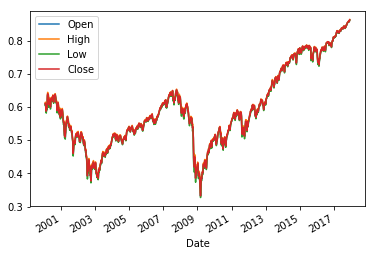

In [5]:
target.plot()

In [37]:
# data generator for training and validation of stateless lstm
def generate_train_data(df, label, test_split=0.2, valid_split=0.1, seq_len=365):
    # prepare output
    out = {}
    
    # get shortest data length (assuming all data start at the same time)
    data_len = len(df[0])-seq_len
    test_split_len = int(data_len*(1-test_split-valid_split))
    valid_split_len = int(data_len*(1-valid_split))
    
    # print out data information
    for i in df:
        print(len(i.columns), end=", ")
    print()
    for i in df:
        print(len(i), end=", ")
    
    # create feature sequence
    for i in range(len(df)):
        df[i] = np.array([np.array(df[i].iloc[j:j+seq_len, :]) for j in range(data_len)])
        out["train_df" + str(i)] = df[i][:test_split_len]
        out["test_df" + str(i)] = df[i][test_split_len:valid_split_len]
        out["valid_df" + str(i)] = df[i][valid_split_len:]

    # convert label to categorical format and find sample weight for each
    # analyze and store a counter-sample-bias output weight
    count = label.iloc[:test_split_len, 0].value_counts()
    for i in range(1, len(label.columns)):
        count += label.iloc[:test_split_len, i].value_counts()
    count = count / count.min()
    weight = 1 / count
    weight /= weight.max()

    def to_weight(label_data):
        out = np.array([weight[int(i)] for i in label_data])
        return out
    
    # create label sequence
    label = np.array([np.array(label.iloc[i+seq_len, :]) for i in range(data_len)]).T # watch out for the shift here
    for i in range(4):
        sample_weight = to_weight(label[i])
        new_label = to_categorical(label[i], num_classes=3)
        out["train_label"+str(i)+"_weight"] = sample_weight[:test_split_len]
#         out["test_label"+str(i)+"_sample_weight"] = sample_weight[test_split_len:valid_split_len]
#         out["valid_label"+str(i)+"_sample_weight"] = sample_weight[valid_split_len:]
        out["train_label"+str(i)] = new_label[:test_split_len]
        out["test_label"+str(i)] = new_label[test_split_len:valid_split_len]
        out["valid_label"+str(i)] = new_label[valid_split_len:]
        
    return out

In [38]:
# generate data
seq_len = 100
train_data = generate_train_data([slow_df, quick_df, target], 
                                 label, seq_len=seq_len, test_split=0.1, valid_split=0.1)

25, 18, 4, 
4484, 4484, 4484, 

In [39]:
def visualize_seq_and_label(train_data):
    x = np.arange(0, seq_len)
    for i in range(len(train_data['train_df2'])):
        for j in range(4):
            y = train_data['train_df2'][i].T[j]
            l = train_data['train_label'+str(j)][i]
            if l.argmax() == 0:
                print("down")
            elif l.argmax() == 1:
                print("stay")
            else:
                print("up")
            plt.figure()
            plt.plot(x, y)
            plt.show()

In [41]:
train_data['train_df2'] = train_data['train_df2'].reshape((-1, seq_len*4))
train_data['test_df2'] = train_data['test_df2'].reshape((-1, seq_len*4))
train_data['valid_df2'] = train_data['valid_df2'].reshape((-1, seq_len*4))

### Quite surprisingly, sometimes using fully connected NN to learn achieves better result than LSTM

In [42]:
# flow for prev_label_input
prev_target_input = Input(shape=(seq_len, 4))
x = prev_target_input
# x = BatchNormalization()(x)
x = LSTM(units=256, activation="relu", kernel_regularizer=l2(l=0.01), return_sequences=False)(x)
prev_target_input = Input(shape=(seq_len*4,))
x = Dense(units=128, activation="relu")(prev_target_input)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
output1 = Dense(units=3, activation="softmax")(x)
output2 = Dense(units=3, activation="softmax")(x)
output3 = Dense(units=3, activation="softmax")(x)
output4 = Dense(units=3, activation="softmax")(x)

# compile model
Indexer = Model(inputs=[prev_target_input], outputs=[output1, output2, output3, output4])
Indexer.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["categorical_crossentropy"])

# display model
plot_model(model=Indexer, to_file="temp.png")
Indexer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 128)          51328       input_9[0][0]                    
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 3)            387         dense_28[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 3)            387         dense_28[0][0]                   
__________________________________________________________________________________________________
dense_31 (

In [43]:
valid_output = [train_data['test_label0'], train_data['test_label1'], train_data['test_label2'], train_data['test_label3']]
train_output = [train_data['train_label0'], train_data['train_label1'], train_data['train_label2'], train_data['train_label3']]

Indexer.fit(x=train_data["train_df2"], y=train_output, 
            validation_data=[train_data["test_df2"], valid_output],
            epochs=1000, batch_size=256, shuffle=True, verbose=1,
            sample_weight=[train_data['train_label0_weight'], train_data["train_label1_weight"], 
                          train_data['train_label2_weight'], train_data['train_label3_weight']])


Train on 3507 samples, validate on 438 samples
Epoch 1/1000
3507/3507 [==============================] - 1s 216us/step - loss: 1.6344 - dense_29_loss: 0.4022 - dense_30_loss: 0.4106 - dense_31_loss: 0.4124 - dense_32_loss: 0.4092 - dense_29_categorical_crossentropy: 1.1430 - dense_30_categorical_crossentropy: 1.1620 - dense_31_categorical_crossentropy: 1.1694 - dense_32_categorical_crossentropy: 1.1504 - val_loss: 4.5831 - val_dense_29_loss: 1.1622 - val_dense_30_loss: 1.1251 - val_dense_31_loss: 1.1798 - val_dense_32_loss: 1.1161 - val_dense_29_categorical_crossentropy: 1.1622 - val_dense_30_categorical_crossentropy: 1.1251 - val_dense_31_categorical_crossentropy: 1.1798 - val_dense_32_categorical_crossentropy: 1.1161
Epoch 2/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.6134 - dense_29_loss: 0.4029 - dense_30_loss: 0.4127 - dense_31_loss: 0.3977 - dense_32_loss: 0.4001 - dense_29_categorical_crossentropy: 1.1153 - dense_30_categorical_crossentropy: 1.1587 -

Epoch 13/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5785 - dense_29_loss: 0.3927 - dense_30_loss: 0.3978 - dense_31_loss: 0.3936 - dense_32_loss: 0.3944 - dense_29_categorical_crossentropy: 1.1211 - dense_30_categorical_crossentropy: 1.1049 - dense_31_categorical_crossentropy: 1.1117 - dense_32_categorical_crossentropy: 1.0982 - val_loss: 4.4185 - val_dense_29_loss: 1.0893 - val_dense_30_loss: 1.1074 - val_dense_31_loss: 1.1100 - val_dense_32_loss: 1.1117 - val_dense_29_categorical_crossentropy: 1.0893 - val_dense_30_categorical_crossentropy: 1.1074 - val_dense_31_categorical_crossentropy: 1.1100 - val_dense_32_categorical_crossentropy: 1.1117
Epoch 14/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5951 - dense_29_loss: 0.3994 - dense_30_loss: 0.4011 - dense_31_loss: 0.3946 - dense_32_loss: 0.3999 - dense_29_categorical_crossentropy: 1.0995 - dense_30_categorical_crossentropy: 1.1158 - dense_31_categorical_crossentropy: 1.0989 - d

3507/3507 [==============================] - 0s 17us/step - loss: 1.5699 - dense_29_loss: 0.3914 - dense_30_loss: 0.3936 - dense_31_loss: 0.3900 - dense_32_loss: 0.3949 - dense_29_categorical_crossentropy: 1.0942 - dense_30_categorical_crossentropy: 1.0874 - dense_31_categorical_crossentropy: 1.0874 - dense_32_categorical_crossentropy: 1.1031 - val_loss: 4.3703 - val_dense_29_loss: 1.0873 - val_dense_30_loss: 1.0755 - val_dense_31_loss: 1.1134 - val_dense_32_loss: 1.0941 - val_dense_29_categorical_crossentropy: 1.0873 - val_dense_30_categorical_crossentropy: 1.0755 - val_dense_31_categorical_crossentropy: 1.1134 - val_dense_32_categorical_crossentropy: 1.0941
Epoch 26/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5681 - dense_29_loss: 0.3907 - dense_30_loss: 0.3950 - dense_31_loss: 0.3901 - dense_32_loss: 0.3923 - dense_29_categorical_crossentropy: 1.1009 - dense_30_categorical_crossentropy: 1.1224 - dense_31_categorical_crossentropy: 1.1071 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5538 - dense_29_loss: 0.3867 - dense_30_loss: 0.3904 - dense_31_loss: 0.3867 - dense_32_loss: 0.3900 - dense_29_categorical_crossentropy: 1.0817 - dense_30_categorical_crossentropy: 1.0974 - dense_31_categorical_crossentropy: 1.0888 - dense_32_categorical_crossentropy: 1.0975 - val_loss: 4.3431 - val_dense_29_loss: 1.0847 - val_dense_30_loss: 1.0813 - val_dense_31_loss: 1.0925 - val_dense_32_loss: 1.0846 - val_dense_29_categorical_crossentropy: 1.0847 - val_dense_30_categorical_crossentropy: 1.0813 - val_dense_31_categorical_crossentropy: 1.0925 - val_dense_32_categorical_crossentropy: 1.0846
Epoch 38/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5585 - dense_29_loss: 0.3880 - dense_30_loss: 0.3915 - dense_31_loss: 0.3881 - dense_32_loss: 0.3909 - dense_29_categorical_crossentropy: 1.0857 - dense_30_categorical_crossentropy: 1.0978 - dense_31_categorical_crossentropy: 1.0872 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5522 - dense_29_loss: 0.3860 - dense_30_loss: 0.3893 - dense_31_loss: 0.3866 - dense_32_loss: 0.3904 - dense_29_categorical_crossentropy: 1.0811 - dense_30_categorical_crossentropy: 1.0891 - dense_31_categorical_crossentropy: 1.0840 - dense_32_categorical_crossentropy: 1.0953 - val_loss: 4.4012 - val_dense_29_loss: 1.1156 - val_dense_30_loss: 1.0846 - val_dense_31_loss: 1.1088 - val_dense_32_loss: 1.0922 - val_dense_29_categorical_crossentropy: 1.1156 - val_dense_30_categorical_crossentropy: 1.0846 - val_dense_31_categorical_crossentropy: 1.1088 - val_dense_32_categorical_crossentropy: 1.0922
Epoch 50/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5438 - dense_29_loss: 0.3843 - dense_30_loss: 0.3874 - dense_31_loss: 0.3841 - dense_32_loss: 0.3880 - dense_29_categorical_crossentropy: 1.0725 - dense_30_categorical_crossentropy: 1.0863 - dense_31_categorical_crossentropy: 1.0825 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5401 - dense_29_loss: 0.3838 - dense_30_loss: 0.3853 - dense_31_loss: 0.3829 - dense_32_loss: 0.3881 - dense_29_categorical_crossentropy: 1.0784 - dense_30_categorical_crossentropy: 1.0807 - dense_31_categorical_crossentropy: 1.0629 - dense_32_categorical_crossentropy: 1.0813 - val_loss: 4.4734 - val_dense_29_loss: 1.1433 - val_dense_30_loss: 1.1010 - val_dense_31_loss: 1.1158 - val_dense_32_loss: 1.1132 - val_dense_29_categorical_crossentropy: 1.1433 - val_dense_30_categorical_crossentropy: 1.1010 - val_dense_31_categorical_crossentropy: 1.1158 - val_dense_32_categorical_crossentropy: 1.1132
Epoch 62/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5353 - dense_29_loss: 0.3815 - dense_30_loss: 0.3846 - dense_31_loss: 0.3823 - dense_32_loss: 0.3870 - dense_29_categorical_crossentropy: 1.0601 - dense_30_categorical_crossentropy: 1.0697 - dense_31_categorical_crossentropy: 1.0670 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5304 - dense_29_loss: 0.3813 - dense_30_loss: 0.3834 - dense_31_loss: 0.3810 - dense_32_loss: 0.3848 - dense_29_categorical_crossentropy: 1.0786 - dense_30_categorical_crossentropy: 1.0830 - dense_31_categorical_crossentropy: 1.0732 - dense_32_categorical_crossentropy: 1.0844 - val_loss: 4.3275 - val_dense_29_loss: 1.0896 - val_dense_30_loss: 1.0628 - val_dense_31_loss: 1.0858 - val_dense_32_loss: 1.0893 - val_dense_29_categorical_crossentropy: 1.0896 - val_dense_30_categorical_crossentropy: 1.0628 - val_dense_31_categorical_crossentropy: 1.0858 - val_dense_32_categorical_crossentropy: 1.0893
Epoch 74/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5350 - dense_29_loss: 0.3832 - dense_30_loss: 0.3847 - dense_31_loss: 0.3816 - dense_32_loss: 0.3856 - dense_29_categorical_crossentropy: 1.0596 - dense_30_categorical_crossentropy: 1.0668 - dense_31_categorical_crossentropy: 1.0673 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5215 - dense_29_loss: 0.3792 - dense_30_loss: 0.3818 - dense_31_loss: 0.3786 - dense_32_loss: 0.3819 - dense_29_categorical_crossentropy: 1.0324 - dense_30_categorical_crossentropy: 1.0474 - dense_31_categorical_crossentropy: 1.0512 - dense_32_categorical_crossentropy: 1.0583 - val_loss: 4.3140 - val_dense_29_loss: 1.0821 - val_dense_30_loss: 1.0564 - val_dense_31_loss: 1.0900 - val_dense_32_loss: 1.0856 - val_dense_29_categorical_crossentropy: 1.0821 - val_dense_30_categorical_crossentropy: 1.0564 - val_dense_31_categorical_crossentropy: 1.0900 - val_dense_32_categorical_crossentropy: 1.0856
Epoch 86/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5376 - dense_29_loss: 0.3843 - dense_30_loss: 0.3852 - dense_31_loss: 0.3823 - dense_32_loss: 0.3857 - dense_29_categorical_crossentropy: 1.0800 - dense_30_categorical_crossentropy: 1.0924 - dense_31_categorical_crossentropy: 1.0807 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5187 - dense_29_loss: 0.3777 - dense_30_loss: 0.3804 - dense_31_loss: 0.3783 - dense_32_loss: 0.3822 - dense_29_categorical_crossentropy: 1.0412 - dense_30_categorical_crossentropy: 1.0460 - dense_31_categorical_crossentropy: 1.0410 - dense_32_categorical_crossentropy: 1.0509 - val_loss: 4.6442 - val_dense_29_loss: 1.1691 - val_dense_30_loss: 1.1580 - val_dense_31_loss: 1.1653 - val_dense_32_loss: 1.1517 - val_dense_29_categorical_crossentropy: 1.1691 - val_dense_30_categorical_crossentropy: 1.1580 - val_dense_31_categorical_crossentropy: 1.1653 - val_dense_32_categorical_crossentropy: 1.1517
Epoch 98/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5295 - dense_29_loss: 0.3813 - dense_30_loss: 0.3830 - dense_31_loss: 0.3807 - dense_32_loss: 0.3845 - dense_29_categorical_crossentropy: 1.0591 - dense_30_categorical_crossentropy: 1.0688 - dense_31_categorical_crossentropy: 1.0650 - dense_32_catego

3507/3507 [==============================] - 0s 16us/step - loss: 1.5137 - dense_29_loss: 0.3755 - dense_30_loss: 0.3789 - dense_31_loss: 0.3774 - dense_32_loss: 0.3819 - dense_29_categorical_crossentropy: 1.0353 - dense_30_categorical_crossentropy: 1.0336 - dense_31_categorical_crossentropy: 1.0357 - dense_32_categorical_crossentropy: 1.0308 - val_loss: 4.3438 - val_dense_29_loss: 1.0778 - val_dense_30_loss: 1.0729 - val_dense_31_loss: 1.1039 - val_dense_32_loss: 1.0892 - val_dense_29_categorical_crossentropy: 1.0778 - val_dense_30_categorical_crossentropy: 1.0729 - val_dense_31_categorical_crossentropy: 1.1039 - val_dense_32_categorical_crossentropy: 1.0892
Epoch 110/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5062 - dense_29_loss: 0.3743 - dense_30_loss: 0.3772 - dense_31_loss: 0.3755 - dense_32_loss: 0.3791 - dense_29_categorical_crossentropy: 1.0331 - dense_30_categorical_crossentropy: 1.0467 - dense_31_categorical_crossentropy: 1.0424 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.5100 - dense_29_loss: 0.3752 - dense_30_loss: 0.3783 - dense_31_loss: 0.3764 - dense_32_loss: 0.3800 - dense_29_categorical_crossentropy: 1.0431 - dense_30_categorical_crossentropy: 1.0468 - dense_31_categorical_crossentropy: 1.0442 - dense_32_categorical_crossentropy: 1.0552 - val_loss: 4.1960 - val_dense_29_loss: 1.0431 - val_dense_30_loss: 1.0301 - val_dense_31_loss: 1.0688 - val_dense_32_loss: 1.0540 - val_dense_29_categorical_crossentropy: 1.0431 - val_dense_30_categorical_crossentropy: 1.0301 - val_dense_31_categorical_crossentropy: 1.0688 - val_dense_32_categorical_crossentropy: 1.0540
Epoch 122/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5077 - dense_29_loss: 0.3739 - dense_30_loss: 0.3777 - dense_31_loss: 0.3765 - dense_32_loss: 0.3795 - dense_29_categorical_crossentropy: 1.0394 - dense_30_categorical_crossentropy: 1.0511 - dense_31_categorical_crossentropy: 1.0589 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4975 - dense_29_loss: 0.3720 - dense_30_loss: 0.3754 - dense_31_loss: 0.3733 - dense_32_loss: 0.3769 - dense_29_categorical_crossentropy: 1.0365 - dense_30_categorical_crossentropy: 1.0420 - dense_31_categorical_crossentropy: 1.0418 - dense_32_categorical_crossentropy: 1.0581 - val_loss: 4.6770 - val_dense_29_loss: 1.1827 - val_dense_30_loss: 1.1695 - val_dense_31_loss: 1.1554 - val_dense_32_loss: 1.1695 - val_dense_29_categorical_crossentropy: 1.1827 - val_dense_30_categorical_crossentropy: 1.1695 - val_dense_31_categorical_crossentropy: 1.1554 - val_dense_32_categorical_crossentropy: 1.1695
Epoch 134/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.5243 - dense_29_loss: 0.3795 - dense_30_loss: 0.3831 - dense_31_loss: 0.3789 - dense_32_loss: 0.3828 - dense_29_categorical_crossentropy: 1.0535 - dense_30_categorical_crossentropy: 1.0730 - dense_31_categorical_crossentropy: 1.0523 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4863 - dense_29_loss: 0.3693 - dense_30_loss: 0.3727 - dense_31_loss: 0.3698 - dense_32_loss: 0.3745 - dense_29_categorical_crossentropy: 1.0255 - dense_30_categorical_crossentropy: 1.0419 - dense_31_categorical_crossentropy: 1.0297 - dense_32_categorical_crossentropy: 1.0408 - val_loss: 4.2382 - val_dense_29_loss: 1.0577 - val_dense_30_loss: 1.0473 - val_dense_31_loss: 1.0680 - val_dense_32_loss: 1.0652 - val_dense_29_categorical_crossentropy: 1.0577 - val_dense_30_categorical_crossentropy: 1.0473 - val_dense_31_categorical_crossentropy: 1.0680 - val_dense_32_categorical_crossentropy: 1.0652
Epoch 146/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4823 - dense_29_loss: 0.3674 - dense_30_loss: 0.3714 - dense_31_loss: 0.3698 - dense_32_loss: 0.3738 - dense_29_categorical_crossentropy: 0.9932 - dense_30_categorical_crossentropy: 1.0006 - dense_31_categorical_crossentropy: 1.0086 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4773 - dense_29_loss: 0.3665 - dense_30_loss: 0.3697 - dense_31_loss: 0.3684 - dense_32_loss: 0.3726 - dense_29_categorical_crossentropy: 1.0114 - dense_30_categorical_crossentropy: 1.0228 - dense_31_categorical_crossentropy: 1.0245 - dense_32_categorical_crossentropy: 1.0301 - val_loss: 4.2500 - val_dense_29_loss: 1.0644 - val_dense_30_loss: 1.0439 - val_dense_31_loss: 1.0712 - val_dense_32_loss: 1.0705 - val_dense_29_categorical_crossentropy: 1.0644 - val_dense_30_categorical_crossentropy: 1.0439 - val_dense_31_categorical_crossentropy: 1.0712 - val_dense_32_categorical_crossentropy: 1.0705
Epoch 158/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4818 - dense_29_loss: 0.3673 - dense_30_loss: 0.3712 - dense_31_loss: 0.3697 - dense_32_loss: 0.3735 - dense_29_categorical_crossentropy: 1.0079 - dense_30_categorical_crossentropy: 1.0231 - dense_31_categorical_crossentropy: 1.0146 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4928 - dense_29_loss: 0.3712 - dense_30_loss: 0.3746 - dense_31_loss: 0.3718 - dense_32_loss: 0.3752 - dense_29_categorical_crossentropy: 1.0339 - dense_30_categorical_crossentropy: 1.0443 - dense_31_categorical_crossentropy: 1.0371 - dense_32_categorical_crossentropy: 1.0446 - val_loss: 4.3233 - val_dense_29_loss: 1.0818 - val_dense_30_loss: 1.0716 - val_dense_31_loss: 1.0838 - val_dense_32_loss: 1.0862 - val_dense_29_categorical_crossentropy: 1.0818 - val_dense_30_categorical_crossentropy: 1.0716 - val_dense_31_categorical_crossentropy: 1.0838 - val_dense_32_categorical_crossentropy: 1.0862
Epoch 170/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4712 - dense_29_loss: 0.3642 - dense_30_loss: 0.3675 - dense_31_loss: 0.3671 - dense_32_loss: 0.3724 - dense_29_categorical_crossentropy: 1.0001 - dense_30_categorical_crossentropy: 1.0117 - dense_31_categorical_crossentropy: 1.0094 - dense_32_categ

3507/3507 [==============================] - 0s 18us/step - loss: 1.4651 - dense_29_loss: 0.3631 - dense_30_loss: 0.3673 - dense_31_loss: 0.3649 - dense_32_loss: 0.3698 - dense_29_categorical_crossentropy: 0.9890 - dense_30_categorical_crossentropy: 0.9996 - dense_31_categorical_crossentropy: 0.9923 - dense_32_categorical_crossentropy: 1.0117 - val_loss: 4.1891 - val_dense_29_loss: 1.0390 - val_dense_30_loss: 1.0285 - val_dense_31_loss: 1.0701 - val_dense_32_loss: 1.0515 - val_dense_29_categorical_crossentropy: 1.0390 - val_dense_30_categorical_crossentropy: 1.0285 - val_dense_31_categorical_crossentropy: 1.0701 - val_dense_32_categorical_crossentropy: 1.0515
Epoch 182/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4590 - dense_29_loss: 0.3616 - dense_30_loss: 0.3654 - dense_31_loss: 0.3632 - dense_32_loss: 0.3688 - dense_29_categorical_crossentropy: 0.9825 - dense_30_categorical_crossentropy: 0.9917 - dense_31_categorical_crossentropy: 0.9899 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4495 - dense_29_loss: 0.3590 - dense_30_loss: 0.3625 - dense_31_loss: 0.3617 - dense_32_loss: 0.3664 - dense_29_categorical_crossentropy: 0.9714 - dense_30_categorical_crossentropy: 0.9846 - dense_31_categorical_crossentropy: 0.9812 - dense_32_categorical_crossentropy: 1.0004 - val_loss: 4.1274 - val_dense_29_loss: 1.0158 - val_dense_30_loss: 1.0075 - val_dense_31_loss: 1.0657 - val_dense_32_loss: 1.0384 - val_dense_29_categorical_crossentropy: 1.0158 - val_dense_30_categorical_crossentropy: 1.0075 - val_dense_31_categorical_crossentropy: 1.0657 - val_dense_32_categorical_crossentropy: 1.0384
Epoch 194/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4595 - dense_29_loss: 0.3619 - dense_30_loss: 0.3652 - dense_31_loss: 0.3640 - dense_32_loss: 0.3684 - dense_29_categorical_crossentropy: 0.9902 - dense_30_categorical_crossentropy: 0.9969 - dense_31_categorical_crossentropy: 1.0043 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4548 - dense_29_loss: 0.3601 - dense_30_loss: 0.3641 - dense_31_loss: 0.3632 - dense_32_loss: 0.3674 - dense_29_categorical_crossentropy: 0.9814 - dense_30_categorical_crossentropy: 0.9786 - dense_31_categorical_crossentropy: 0.9852 - dense_32_categorical_crossentropy: 0.9988 - val_loss: 4.4908 - val_dense_29_loss: 1.1209 - val_dense_30_loss: 1.1063 - val_dense_31_loss: 1.1463 - val_dense_32_loss: 1.1173 - val_dense_29_categorical_crossentropy: 1.1209 - val_dense_30_categorical_crossentropy: 1.1063 - val_dense_31_categorical_crossentropy: 1.1463 - val_dense_32_categorical_crossentropy: 1.1173
Epoch 206/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4450 - dense_29_loss: 0.3578 - dense_30_loss: 0.3615 - dense_31_loss: 0.3604 - dense_32_loss: 0.3654 - dense_29_categorical_crossentropy: 0.9847 - dense_30_categorical_crossentropy: 1.0049 - dense_31_categorical_crossentropy: 1.0025 - dense_32_categ

3507/3507 [==============================] - 0s 17us/step - loss: 1.4542 - dense_29_loss: 0.3602 - dense_30_loss: 0.3635 - dense_31_loss: 0.3631 - dense_32_loss: 0.3674 - dense_29_categorical_crossentropy: 0.9860 - dense_30_categorical_crossentropy: 1.0026 - dense_31_categorical_crossentropy: 1.0029 - dense_32_categorical_crossentropy: 1.0113 - val_loss: 4.0993 - val_dense_29_loss: 1.0164 - val_dense_30_loss: 1.0041 - val_dense_31_loss: 1.0452 - val_dense_32_loss: 1.0337 - val_dense_29_categorical_crossentropy: 1.0164 - val_dense_30_categorical_crossentropy: 1.0041 - val_dense_31_categorical_crossentropy: 1.0452 - val_dense_32_categorical_crossentropy: 1.0337
Epoch 218/1000
3507/3507 [==============================] - 0s 19us/step - loss: 1.4517 - dense_29_loss: 0.3597 - dense_30_loss: 0.3630 - dense_31_loss: 0.3619 - dense_32_loss: 0.3670 - dense_29_categorical_crossentropy: 0.9759 - dense_30_categorical_crossentropy: 0.9832 - dense_31_categorical_crossentropy: 0.9866 - dense_32_categ

3507/3507 [==============================] - 0s 20us/step - loss: 1.4678 - dense_29_loss: 0.3639 - dense_30_loss: 0.3673 - dense_31_loss: 0.3662 - dense_32_loss: 0.3703 - dense_29_categorical_crossentropy: 1.0086 - dense_30_categorical_crossentropy: 1.0192 - dense_31_categorical_crossentropy: 1.0183 - dense_32_categorical_crossentropy: 1.0292 - val_loss: 4.1363 - val_dense_29_loss: 1.0214 - val_dense_30_loss: 1.0117 - val_dense_31_loss: 1.0700 - val_dense_32_loss: 1.0332 - val_dense_29_categorical_crossentropy: 1.0214 - val_dense_30_categorical_crossentropy: 1.0117 - val_dense_31_categorical_crossentropy: 1.0700 - val_dense_32_categorical_crossentropy: 1.0332
Epoch 230/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4554 - dense_29_loss: 0.3608 - dense_30_loss: 0.3641 - dense_31_loss: 0.3631 - dense_32_loss: 0.3674 - dense_29_categorical_crossentropy: 0.9850 - dense_30_categorical_crossentropy: 0.9943 - dense_31_categorical_crossentropy: 0.9976 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4405 - dense_29_loss: 0.3571 - dense_30_loss: 0.3597 - dense_31_loss: 0.3598 - dense_32_loss: 0.3639 - dense_29_categorical_crossentropy: 0.9642 - dense_30_categorical_crossentropy: 0.9819 - dense_31_categorical_crossentropy: 0.9780 - dense_32_categorical_crossentropy: 0.9917 - val_loss: 4.3181 - val_dense_29_loss: 1.0712 - val_dense_30_loss: 1.0573 - val_dense_31_loss: 1.1026 - val_dense_32_loss: 1.0870 - val_dense_29_categorical_crossentropy: 1.0712 - val_dense_30_categorical_crossentropy: 1.0573 - val_dense_31_categorical_crossentropy: 1.1026 - val_dense_32_categorical_crossentropy: 1.0870
Epoch 242/1000
3507/3507 [==============================] - 0s 19us/step - loss: 1.4466 - dense_29_loss: 0.3582 - dense_30_loss: 0.3614 - dense_31_loss: 0.3613 - dense_32_loss: 0.3657 - dense_29_categorical_crossentropy: 0.9931 - dense_30_categorical_crossentropy: 0.9977 - dense_31_categorical_crossentropy: 0.9975 - dense_32_categ

3507/3507 [==============================] - 0s 17us/step - loss: 1.4411 - dense_29_loss: 0.3566 - dense_30_loss: 0.3602 - dense_31_loss: 0.3595 - dense_32_loss: 0.3647 - dense_29_categorical_crossentropy: 0.9790 - dense_30_categorical_crossentropy: 0.9869 - dense_31_categorical_crossentropy: 0.9896 - dense_32_categorical_crossentropy: 1.0037 - val_loss: 4.2956 - val_dense_29_loss: 1.0781 - val_dense_30_loss: 1.0603 - val_dense_31_loss: 1.0783 - val_dense_32_loss: 1.0788 - val_dense_29_categorical_crossentropy: 1.0781 - val_dense_30_categorical_crossentropy: 1.0603 - val_dense_31_categorical_crossentropy: 1.0783 - val_dense_32_categorical_crossentropy: 1.0788
Epoch 254/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4293 - dense_29_loss: 0.3542 - dense_30_loss: 0.3567 - dense_31_loss: 0.3568 - dense_32_loss: 0.3617 - dense_29_categorical_crossentropy: 0.9741 - dense_30_categorical_crossentropy: 0.9796 - dense_31_categorical_crossentropy: 0.9794 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4625 - dense_29_loss: 0.3627 - dense_30_loss: 0.3659 - dense_31_loss: 0.3651 - dense_32_loss: 0.3688 - dense_29_categorical_crossentropy: 0.9801 - dense_30_categorical_crossentropy: 0.9898 - dense_31_categorical_crossentropy: 0.9954 - dense_32_categorical_crossentropy: 0.9998 - val_loss: 4.1178 - val_dense_29_loss: 1.0124 - val_dense_30_loss: 1.0015 - val_dense_31_loss: 1.0666 - val_dense_32_loss: 1.0374 - val_dense_29_categorical_crossentropy: 1.0124 - val_dense_30_categorical_crossentropy: 1.0015 - val_dense_31_categorical_crossentropy: 1.0666 - val_dense_32_categorical_crossentropy: 1.0374
Epoch 266/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4274 - dense_29_loss: 0.3528 - dense_30_loss: 0.3562 - dense_31_loss: 0.3567 - dense_32_loss: 0.3616 - dense_29_categorical_crossentropy: 0.9600 - dense_30_categorical_crossentropy: 0.9722 - dense_31_categorical_crossentropy: 0.9667 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4254 - dense_29_loss: 0.3529 - dense_30_loss: 0.3561 - dense_31_loss: 0.3560 - dense_32_loss: 0.3605 - dense_29_categorical_crossentropy: 0.9581 - dense_30_categorical_crossentropy: 0.9713 - dense_31_categorical_crossentropy: 0.9803 - dense_32_categorical_crossentropy: 0.9926 - val_loss: 3.9673 - val_dense_29_loss: 0.9745 - val_dense_30_loss: 0.9665 - val_dense_31_loss: 1.0264 - val_dense_32_loss: 1.0000 - val_dense_29_categorical_crossentropy: 0.9745 - val_dense_30_categorical_crossentropy: 0.9665 - val_dense_31_categorical_crossentropy: 1.0264 - val_dense_32_categorical_crossentropy: 1.0000
Epoch 278/1000
3507/3507 [==============================] - 0s 17us/step - loss: 1.4505 - dense_29_loss: 0.3592 - dense_30_loss: 0.3629 - dense_31_loss: 0.3618 - dense_32_loss: 0.3666 - dense_29_categorical_crossentropy: 0.9897 - dense_30_categorical_crossentropy: 0.9996 - dense_31_categorical_crossentropy: 0.9949 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4207 - dense_29_loss: 0.3514 - dense_30_loss: 0.3548 - dense_31_loss: 0.3547 - dense_32_loss: 0.3598 - dense_29_categorical_crossentropy: 0.9528 - dense_30_categorical_crossentropy: 0.9678 - dense_31_categorical_crossentropy: 0.9662 - dense_32_categorical_crossentropy: 0.9827 - val_loss: 4.0008 - val_dense_29_loss: 0.9785 - val_dense_30_loss: 0.9725 - val_dense_31_loss: 1.0425 - val_dense_32_loss: 1.0074 - val_dense_29_categorical_crossentropy: 0.9785 - val_dense_30_categorical_crossentropy: 0.9725 - val_dense_31_categorical_crossentropy: 1.0425 - val_dense_32_categorical_crossentropy: 1.0074
Epoch 290/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4117 - dense_29_loss: 0.3489 - dense_30_loss: 0.3524 - dense_31_loss: 0.3526 - dense_32_loss: 0.3578 - dense_29_categorical_crossentropy: 0.9611 - dense_30_categorical_crossentropy: 0.9667 - dense_31_categorical_crossentropy: 0.9702 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4164 - dense_29_loss: 0.3503 - dense_30_loss: 0.3537 - dense_31_loss: 0.3538 - dense_32_loss: 0.3586 - dense_29_categorical_crossentropy: 0.9473 - dense_30_categorical_crossentropy: 0.9529 - dense_31_categorical_crossentropy: 0.9551 - dense_32_categorical_crossentropy: 0.9715 - val_loss: 4.0329 - val_dense_29_loss: 0.9941 - val_dense_30_loss: 0.9819 - val_dense_31_loss: 1.0389 - val_dense_32_loss: 1.0179 - val_dense_29_categorical_crossentropy: 0.9941 - val_dense_30_categorical_crossentropy: 0.9819 - val_dense_31_categorical_crossentropy: 1.0389 - val_dense_32_categorical_crossentropy: 1.0179
Epoch 302/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4079 - dense_29_loss: 0.3479 - dense_30_loss: 0.3513 - dense_31_loss: 0.3518 - dense_32_loss: 0.3570 - dense_29_categorical_crossentropy: 0.9521 - dense_30_categorical_crossentropy: 0.9642 - dense_31_categorical_crossentropy: 0.9718 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4112 - dense_29_loss: 0.3489 - dense_30_loss: 0.3522 - dense_31_loss: 0.3527 - dense_32_loss: 0.3573 - dense_29_categorical_crossentropy: 0.9392 - dense_30_categorical_crossentropy: 0.9473 - dense_31_categorical_crossentropy: 0.9539 - dense_32_categorical_crossentropy: 0.9635 - val_loss: 4.1138 - val_dense_29_loss: 1.0210 - val_dense_30_loss: 1.0054 - val_dense_31_loss: 1.0492 - val_dense_32_loss: 1.0382 - val_dense_29_categorical_crossentropy: 1.0210 - val_dense_30_categorical_crossentropy: 1.0054 - val_dense_31_categorical_crossentropy: 1.0492 - val_dense_32_categorical_crossentropy: 1.0382
Epoch 314/1000
3507/3507 [==============================] - 0s 18us/step - loss: 1.4157 - dense_29_loss: 0.3498 - dense_30_loss: 0.3533 - dense_31_loss: 0.3539 - dense_32_loss: 0.3587 - dense_29_categorical_crossentropy: 0.9456 - dense_30_categorical_crossentropy: 0.9588 - dense_31_categorical_crossentropy: 0.9608 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4266 - dense_29_loss: 0.3528 - dense_30_loss: 0.3563 - dense_31_loss: 0.3563 - dense_32_loss: 0.3611 - dense_29_categorical_crossentropy: 0.9834 - dense_30_categorical_crossentropy: 0.9964 - dense_31_categorical_crossentropy: 0.9999 - dense_32_categorical_crossentropy: 1.0133 - val_loss: 3.9017 - val_dense_29_loss: 0.9622 - val_dense_30_loss: 0.9557 - val_dense_31_loss: 1.0000 - val_dense_32_loss: 0.9838 - val_dense_29_categorical_crossentropy: 0.9622 - val_dense_30_categorical_crossentropy: 0.9557 - val_dense_31_categorical_crossentropy: 1.0000 - val_dense_32_categorical_crossentropy: 0.9838
Epoch 326/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4476 - dense_29_loss: 0.3571 - dense_30_loss: 0.3620 - dense_31_loss: 0.3619 - dense_32_loss: 0.3666 - dense_29_categorical_crossentropy: 0.9496 - dense_30_categorical_crossentropy: 0.9639 - dense_31_categorical_crossentropy: 0.9670 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4278 - dense_29_loss: 0.3532 - dense_30_loss: 0.3567 - dense_31_loss: 0.3569 - dense_32_loss: 0.3610 - dense_29_categorical_crossentropy: 0.9724 - dense_30_categorical_crossentropy: 0.9796 - dense_31_categorical_crossentropy: 0.9802 - dense_32_categorical_crossentropy: 0.9947 - val_loss: 3.9493 - val_dense_29_loss: 0.9776 - val_dense_30_loss: 0.9682 - val_dense_31_loss: 1.0039 - val_dense_32_loss: 0.9995 - val_dense_29_categorical_crossentropy: 0.9776 - val_dense_30_categorical_crossentropy: 0.9682 - val_dense_31_categorical_crossentropy: 1.0039 - val_dense_32_categorical_crossentropy: 0.9995
Epoch 338/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4008 - dense_29_loss: 0.3460 - dense_30_loss: 0.3493 - dense_31_loss: 0.3506 - dense_32_loss: 0.3549 - dense_29_categorical_crossentropy: 0.9297 - dense_30_categorical_crossentropy: 0.9470 - dense_31_categorical_crossentropy: 0.9575 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4127 - dense_29_loss: 0.3491 - dense_30_loss: 0.3528 - dense_31_loss: 0.3531 - dense_32_loss: 0.3577 - dense_29_categorical_crossentropy: 0.9324 - dense_30_categorical_crossentropy: 0.9429 - dense_31_categorical_crossentropy: 0.9469 - dense_32_categorical_crossentropy: 0.9608 - val_loss: 4.3042 - val_dense_29_loss: 1.0567 - val_dense_30_loss: 1.0507 - val_dense_31_loss: 1.1142 - val_dense_32_loss: 1.0826 - val_dense_29_categorical_crossentropy: 1.0567 - val_dense_30_categorical_crossentropy: 1.0507 - val_dense_31_categorical_crossentropy: 1.1142 - val_dense_32_categorical_crossentropy: 1.0826
Epoch 350/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4235 - dense_29_loss: 0.3515 - dense_30_loss: 0.3557 - dense_31_loss: 0.3557 - dense_32_loss: 0.3606 - dense_29_categorical_crossentropy: 0.9627 - dense_30_categorical_crossentropy: 0.9768 - dense_31_categorical_crossentropy: 0.9779 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3976 - dense_29_loss: 0.3447 - dense_30_loss: 0.3490 - dense_31_loss: 0.3495 - dense_32_loss: 0.3544 - dense_29_categorical_crossentropy: 0.9369 - dense_30_categorical_crossentropy: 0.9480 - dense_31_categorical_crossentropy: 0.9666 - dense_32_categorical_crossentropy: 0.9695 - val_loss: 4.0392 - val_dense_29_loss: 1.0055 - val_dense_30_loss: 0.9890 - val_dense_31_loss: 1.0226 - val_dense_32_loss: 1.0222 - val_dense_29_categorical_crossentropy: 1.0055 - val_dense_30_categorical_crossentropy: 0.9890 - val_dense_31_categorical_crossentropy: 1.0226 - val_dense_32_categorical_crossentropy: 1.0222
Epoch 362/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4171 - dense_29_loss: 0.3504 - dense_30_loss: 0.3538 - dense_31_loss: 0.3541 - dense_32_loss: 0.3588 - dense_29_categorical_crossentropy: 0.9579 - dense_30_categorical_crossentropy: 0.9709 - dense_31_categorical_crossentropy: 0.9642 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3999 - dense_29_loss: 0.3462 - dense_30_loss: 0.3493 - dense_31_loss: 0.3500 - dense_32_loss: 0.3545 - dense_29_categorical_crossentropy: 0.9254 - dense_30_categorical_crossentropy: 0.9382 - dense_31_categorical_crossentropy: 0.9468 - dense_32_categorical_crossentropy: 0.9571 - val_loss: 4.4667 - val_dense_29_loss: 1.1258 - val_dense_30_loss: 1.0997 - val_dense_31_loss: 1.1228 - val_dense_32_loss: 1.1184 - val_dense_29_categorical_crossentropy: 1.1258 - val_dense_30_categorical_crossentropy: 1.0997 - val_dense_31_categorical_crossentropy: 1.1228 - val_dense_32_categorical_crossentropy: 1.1184
Epoch 374/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4108 - dense_29_loss: 0.3492 - dense_30_loss: 0.3519 - dense_31_loss: 0.3526 - dense_32_loss: 0.3572 - dense_29_categorical_crossentropy: 0.9674 - dense_30_categorical_crossentropy: 0.9733 - dense_31_categorical_crossentropy: 0.9763 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4036 - dense_29_loss: 0.3464 - dense_30_loss: 0.3505 - dense_31_loss: 0.3508 - dense_32_loss: 0.3559 - dense_29_categorical_crossentropy: 0.9390 - dense_30_categorical_crossentropy: 0.9518 - dense_31_categorical_crossentropy: 0.9487 - dense_32_categorical_crossentropy: 0.9708 - val_loss: 4.2528 - val_dense_29_loss: 1.0501 - val_dense_30_loss: 1.0498 - val_dense_31_loss: 1.0897 - val_dense_32_loss: 1.0632 - val_dense_29_categorical_crossentropy: 1.0501 - val_dense_30_categorical_crossentropy: 1.0498 - val_dense_31_categorical_crossentropy: 1.0897 - val_dense_32_categorical_crossentropy: 1.0632
Epoch 386/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3981 - dense_29_loss: 0.3450 - dense_30_loss: 0.3485 - dense_31_loss: 0.3498 - dense_32_loss: 0.3548 - dense_29_categorical_crossentropy: 0.9277 - dense_30_categorical_crossentropy: 0.9333 - dense_31_categorical_crossentropy: 0.9457 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4108 - dense_29_loss: 0.3489 - dense_30_loss: 0.3517 - dense_31_loss: 0.3529 - dense_32_loss: 0.3572 - dense_29_categorical_crossentropy: 0.9492 - dense_30_categorical_crossentropy: 0.9630 - dense_31_categorical_crossentropy: 0.9674 - dense_32_categorical_crossentropy: 0.9777 - val_loss: 4.1989 - val_dense_29_loss: 1.0374 - val_dense_30_loss: 1.0237 - val_dense_31_loss: 1.0835 - val_dense_32_loss: 1.0544 - val_dense_29_categorical_crossentropy: 1.0374 - val_dense_30_categorical_crossentropy: 1.0237 - val_dense_31_categorical_crossentropy: 1.0835 - val_dense_32_categorical_crossentropy: 1.0544
Epoch 398/1000
3507/3507 [==============================] - 0s 17us/step - loss: 1.3907 - dense_29_loss: 0.3433 - dense_30_loss: 0.3464 - dense_31_loss: 0.3483 - dense_32_loss: 0.3528 - dense_29_categorical_crossentropy: 0.9238 - dense_30_categorical_crossentropy: 0.9310 - dense_31_categorical_crossentropy: 0.9373 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4203 - dense_29_loss: 0.3514 - dense_30_loss: 0.3549 - dense_31_loss: 0.3547 - dense_32_loss: 0.3593 - dense_29_categorical_crossentropy: 0.9479 - dense_30_categorical_crossentropy: 0.9605 - dense_31_categorical_crossentropy: 0.9660 - dense_32_categorical_crossentropy: 0.9786 - val_loss: 4.0270 - val_dense_29_loss: 0.9964 - val_dense_30_loss: 0.9792 - val_dense_31_loss: 1.0335 - val_dense_32_loss: 1.0178 - val_dense_29_categorical_crossentropy: 0.9964 - val_dense_30_categorical_crossentropy: 0.9792 - val_dense_31_categorical_crossentropy: 1.0335 - val_dense_32_categorical_crossentropy: 1.0178
Epoch 410/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3972 - dense_29_loss: 0.3454 - dense_30_loss: 0.3484 - dense_31_loss: 0.3493 - dense_32_loss: 0.3541 - dense_29_categorical_crossentropy: 0.9417 - dense_30_categorical_crossentropy: 0.9492 - dense_31_categorical_crossentropy: 0.9516 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3872 - dense_29_loss: 0.3422 - dense_30_loss: 0.3461 - dense_31_loss: 0.3468 - dense_32_loss: 0.3520 - dense_29_categorical_crossentropy: 0.9221 - dense_30_categorical_crossentropy: 0.9357 - dense_31_categorical_crossentropy: 0.9418 - dense_32_categorical_crossentropy: 0.9573 - val_loss: 3.8788 - val_dense_29_loss: 0.9565 - val_dense_30_loss: 0.9450 - val_dense_31_loss: 0.9961 - val_dense_32_loss: 0.9812 - val_dense_29_categorical_crossentropy: 0.9565 - val_dense_30_categorical_crossentropy: 0.9450 - val_dense_31_categorical_crossentropy: 0.9961 - val_dense_32_categorical_crossentropy: 0.9812
Epoch 422/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4636 - dense_29_loss: 0.3635 - dense_30_loss: 0.3654 - dense_31_loss: 0.3654 - dense_32_loss: 0.3692 - dense_29_categorical_crossentropy: 1.0005 - dense_30_categorical_crossentropy: 1.0038 - dense_31_categorical_crossentropy: 1.0084 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4119 - dense_29_loss: 0.3474 - dense_30_loss: 0.3525 - dense_31_loss: 0.3530 - dense_32_loss: 0.3590 - dense_29_categorical_crossentropy: 0.9385 - dense_30_categorical_crossentropy: 0.9470 - dense_31_categorical_crossentropy: 0.9596 - dense_32_categorical_crossentropy: 0.9665 - val_loss: 4.1373 - val_dense_29_loss: 1.0146 - val_dense_30_loss: 1.0037 - val_dense_31_loss: 1.0766 - val_dense_32_loss: 1.0424 - val_dense_29_categorical_crossentropy: 1.0146 - val_dense_30_categorical_crossentropy: 1.0037 - val_dense_31_categorical_crossentropy: 1.0766 - val_dense_32_categorical_crossentropy: 1.0424
Epoch 434/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3952 - dense_29_loss: 0.3435 - dense_30_loss: 0.3479 - dense_31_loss: 0.3496 - dense_32_loss: 0.3543 - dense_29_categorical_crossentropy: 0.9081 - dense_30_categorical_crossentropy: 0.9144 - dense_31_categorical_crossentropy: 0.9247 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3892 - dense_29_loss: 0.3425 - dense_30_loss: 0.3463 - dense_31_loss: 0.3479 - dense_32_loss: 0.3524 - dense_29_categorical_crossentropy: 0.9317 - dense_30_categorical_crossentropy: 0.9423 - dense_31_categorical_crossentropy: 0.9497 - dense_32_categorical_crossentropy: 0.9615 - val_loss: 4.0629 - val_dense_29_loss: 1.0149 - val_dense_30_loss: 0.9890 - val_dense_31_loss: 1.0318 - val_dense_32_loss: 1.0273 - val_dense_29_categorical_crossentropy: 1.0149 - val_dense_30_categorical_crossentropy: 0.9890 - val_dense_31_categorical_crossentropy: 1.0318 - val_dense_32_categorical_crossentropy: 1.0273
Epoch 446/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3852 - dense_29_loss: 0.3420 - dense_30_loss: 0.3450 - dense_31_loss: 0.3467 - dense_32_loss: 0.3515 - dense_29_categorical_crossentropy: 0.9234 - dense_30_categorical_crossentropy: 0.9314 - dense_31_categorical_crossentropy: 0.9437 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4415 - dense_29_loss: 0.3573 - dense_30_loss: 0.3605 - dense_31_loss: 0.3592 - dense_32_loss: 0.3645 - dense_29_categorical_crossentropy: 0.9659 - dense_30_categorical_crossentropy: 0.9792 - dense_31_categorical_crossentropy: 0.9795 - dense_32_categorical_crossentropy: 0.9929 - val_loss: 3.9166 - val_dense_29_loss: 0.9583 - val_dense_30_loss: 0.9517 - val_dense_31_loss: 1.0227 - val_dense_32_loss: 0.9839 - val_dense_29_categorical_crossentropy: 0.9583 - val_dense_30_categorical_crossentropy: 0.9517 - val_dense_31_categorical_crossentropy: 1.0227 - val_dense_32_categorical_crossentropy: 0.9839
Epoch 458/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3989 - dense_29_loss: 0.3454 - dense_30_loss: 0.3491 - dense_31_loss: 0.3497 - dense_32_loss: 0.3547 - dense_29_categorical_crossentropy: 0.9473 - dense_30_categorical_crossentropy: 0.9577 - dense_31_categorical_crossentropy: 0.9572 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3829 - dense_29_loss: 0.3410 - dense_30_loss: 0.3446 - dense_31_loss: 0.3460 - dense_32_loss: 0.3512 - dense_29_categorical_crossentropy: 0.9204 - dense_30_categorical_crossentropy: 0.9348 - dense_31_categorical_crossentropy: 0.9391 - dense_32_categorical_crossentropy: 0.9541 - val_loss: 3.8389 - val_dense_29_loss: 0.9447 - val_dense_30_loss: 0.9321 - val_dense_31_loss: 0.9936 - val_dense_32_loss: 0.9686 - val_dense_29_categorical_crossentropy: 0.9447 - val_dense_30_categorical_crossentropy: 0.9321 - val_dense_31_categorical_crossentropy: 0.9936 - val_dense_32_categorical_crossentropy: 0.9686
Epoch 470/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3912 - dense_29_loss: 0.3431 - dense_30_loss: 0.3467 - dense_31_loss: 0.3483 - dense_32_loss: 0.3530 - dense_29_categorical_crossentropy: 0.9254 - dense_30_categorical_crossentropy: 0.9325 - dense_31_categorical_crossentropy: 0.9455 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3998 - dense_29_loss: 0.3458 - dense_30_loss: 0.3493 - dense_31_loss: 0.3503 - dense_32_loss: 0.3544 - dense_29_categorical_crossentropy: 0.9387 - dense_30_categorical_crossentropy: 0.9500 - dense_31_categorical_crossentropy: 0.9571 - dense_32_categorical_crossentropy: 0.9689 - val_loss: 4.1450 - val_dense_29_loss: 1.0335 - val_dense_30_loss: 1.0171 - val_dense_31_loss: 1.0522 - val_dense_32_loss: 1.0423 - val_dense_29_categorical_crossentropy: 1.0335 - val_dense_30_categorical_crossentropy: 1.0171 - val_dense_31_categorical_crossentropy: 1.0522 - val_dense_32_categorical_crossentropy: 1.0423
Epoch 482/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3779 - dense_29_loss: 0.3399 - dense_30_loss: 0.3431 - dense_31_loss: 0.3448 - dense_32_loss: 0.3502 - dense_29_categorical_crossentropy: 0.9301 - dense_30_categorical_crossentropy: 0.9407 - dense_31_categorical_crossentropy: 0.9508 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3848 - dense_29_loss: 0.3417 - dense_30_loss: 0.3451 - dense_31_loss: 0.3469 - dense_32_loss: 0.3511 - dense_29_categorical_crossentropy: 0.9191 - dense_30_categorical_crossentropy: 0.9268 - dense_31_categorical_crossentropy: 0.9352 - dense_32_categorical_crossentropy: 0.9492 - val_loss: 4.2173 - val_dense_29_loss: 1.0381 - val_dense_30_loss: 1.0287 - val_dense_31_loss: 1.0907 - val_dense_32_loss: 1.0598 - val_dense_29_categorical_crossentropy: 1.0381 - val_dense_30_categorical_crossentropy: 1.0287 - val_dense_31_categorical_crossentropy: 1.0907 - val_dense_32_categorical_crossentropy: 1.0598
Epoch 494/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3900 - dense_29_loss: 0.3431 - dense_30_loss: 0.3467 - dense_31_loss: 0.3478 - dense_32_loss: 0.3525 - dense_29_categorical_crossentropy: 0.9156 - dense_30_categorical_crossentropy: 0.9281 - dense_31_categorical_crossentropy: 0.9353 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.4489 - dense_29_loss: 0.3590 - dense_30_loss: 0.3625 - dense_31_loss: 0.3616 - dense_32_loss: 0.3658 - dense_29_categorical_crossentropy: 0.9706 - dense_30_categorical_crossentropy: 0.9764 - dense_31_categorical_crossentropy: 0.9753 - dense_32_categorical_crossentropy: 0.9937 - val_loss: 3.8823 - val_dense_29_loss: 0.9509 - val_dense_30_loss: 0.9412 - val_dense_31_loss: 1.0126 - val_dense_32_loss: 0.9776 - val_dense_29_categorical_crossentropy: 0.9509 - val_dense_30_categorical_crossentropy: 0.9412 - val_dense_31_categorical_crossentropy: 1.0126 - val_dense_32_categorical_crossentropy: 0.9776
Epoch 506/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4177 - dense_29_loss: 0.3504 - dense_30_loss: 0.3538 - dense_31_loss: 0.3541 - dense_32_loss: 0.3594 - dense_29_categorical_crossentropy: 0.9598 - dense_30_categorical_crossentropy: 0.9706 - dense_31_categorical_crossentropy: 0.9720 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3912 - dense_29_loss: 0.3432 - dense_30_loss: 0.3466 - dense_31_loss: 0.3481 - dense_32_loss: 0.3533 - dense_29_categorical_crossentropy: 0.9465 - dense_30_categorical_crossentropy: 0.9588 - dense_31_categorical_crossentropy: 0.9667 - dense_32_categorical_crossentropy: 0.9805 - val_loss: 3.8576 - val_dense_29_loss: 0.9502 - val_dense_30_loss: 0.9385 - val_dense_31_loss: 0.9944 - val_dense_32_loss: 0.9744 - val_dense_29_categorical_crossentropy: 0.9502 - val_dense_30_categorical_crossentropy: 0.9385 - val_dense_31_categorical_crossentropy: 0.9944 - val_dense_32_categorical_crossentropy: 0.9744
Epoch 518/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3753 - dense_29_loss: 0.3392 - dense_30_loss: 0.3426 - dense_31_loss: 0.3444 - dense_32_loss: 0.3492 - dense_29_categorical_crossentropy: 0.8964 - dense_30_categorical_crossentropy: 0.9094 - dense_31_categorical_crossentropy: 0.9090 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3789 - dense_29_loss: 0.3405 - dense_30_loss: 0.3435 - dense_31_loss: 0.3449 - dense_32_loss: 0.3500 - dense_29_categorical_crossentropy: 0.9263 - dense_30_categorical_crossentropy: 0.9368 - dense_31_categorical_crossentropy: 0.9487 - dense_32_categorical_crossentropy: 0.9568 - val_loss: 3.8407 - val_dense_29_loss: 0.9460 - val_dense_30_loss: 0.9361 - val_dense_31_loss: 0.9867 - val_dense_32_loss: 0.9718 - val_dense_29_categorical_crossentropy: 0.9460 - val_dense_30_categorical_crossentropy: 0.9361 - val_dense_31_categorical_crossentropy: 0.9867 - val_dense_32_categorical_crossentropy: 0.9718
Epoch 530/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3672 - dense_29_loss: 0.3368 - dense_30_loss: 0.3403 - dense_31_loss: 0.3425 - dense_32_loss: 0.3476 - dense_29_categorical_crossentropy: 0.8996 - dense_30_categorical_crossentropy: 0.9178 - dense_31_categorical_crossentropy: 0.9121 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3741 - dense_29_loss: 0.3388 - dense_30_loss: 0.3423 - dense_31_loss: 0.3442 - dense_32_loss: 0.3488 - dense_29_categorical_crossentropy: 0.9188 - dense_30_categorical_crossentropy: 0.9348 - dense_31_categorical_crossentropy: 0.9358 - dense_32_categorical_crossentropy: 0.9528 - val_loss: 4.0579 - val_dense_29_loss: 1.0083 - val_dense_30_loss: 0.9972 - val_dense_31_loss: 1.0308 - val_dense_32_loss: 1.0216 - val_dense_29_categorical_crossentropy: 1.0083 - val_dense_30_categorical_crossentropy: 0.9972 - val_dense_31_categorical_crossentropy: 1.0308 - val_dense_32_categorical_crossentropy: 1.0216
Epoch 542/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3735 - dense_29_loss: 0.3387 - dense_30_loss: 0.3420 - dense_31_loss: 0.3439 - dense_32_loss: 0.3488 - dense_29_categorical_crossentropy: 0.9081 - dense_30_categorical_crossentropy: 0.9181 - dense_31_categorical_crossentropy: 0.9306 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3759 - dense_29_loss: 0.3391 - dense_30_loss: 0.3431 - dense_31_loss: 0.3441 - dense_32_loss: 0.3497 - dense_29_categorical_crossentropy: 0.9179 - dense_30_categorical_crossentropy: 0.9330 - dense_31_categorical_crossentropy: 0.9346 - dense_32_categorical_crossentropy: 0.9557 - val_loss: 3.8157 - val_dense_29_loss: 0.9357 - val_dense_30_loss: 0.9252 - val_dense_31_loss: 0.9938 - val_dense_32_loss: 0.9610 - val_dense_29_categorical_crossentropy: 0.9357 - val_dense_30_categorical_crossentropy: 0.9252 - val_dense_31_categorical_crossentropy: 0.9938 - val_dense_32_categorical_crossentropy: 0.9610
Epoch 554/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3751 - dense_29_loss: 0.3385 - dense_30_loss: 0.3425 - dense_31_loss: 0.3444 - dense_32_loss: 0.3497 - dense_29_categorical_crossentropy: 0.9029 - dense_30_categorical_crossentropy: 0.9165 - dense_31_categorical_crossentropy: 0.9313 - dense_32_categ

3507/3507 [==============================] - 0s 18us/step - loss: 1.3617 - dense_29_loss: 0.3355 - dense_30_loss: 0.3387 - dense_31_loss: 0.3411 - dense_32_loss: 0.3465 - dense_29_categorical_crossentropy: 0.8972 - dense_30_categorical_crossentropy: 0.9074 - dense_31_categorical_crossentropy: 0.9236 - dense_32_categorical_crossentropy: 0.9301 - val_loss: 3.9929 - val_dense_29_loss: 0.9807 - val_dense_30_loss: 0.9698 - val_dense_31_loss: 1.0362 - val_dense_32_loss: 1.0061 - val_dense_29_categorical_crossentropy: 0.9807 - val_dense_30_categorical_crossentropy: 0.9698 - val_dense_31_categorical_crossentropy: 1.0362 - val_dense_32_categorical_crossentropy: 1.0061
Epoch 566/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3673 - dense_29_loss: 0.3371 - dense_30_loss: 0.3403 - dense_31_loss: 0.3423 - dense_32_loss: 0.3475 - dense_29_categorical_crossentropy: 0.9155 - dense_30_categorical_crossentropy: 0.9273 - dense_31_categorical_crossentropy: 0.9285 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3729 - dense_29_loss: 0.3387 - dense_30_loss: 0.3419 - dense_31_loss: 0.3435 - dense_32_loss: 0.3487 - dense_29_categorical_crossentropy: 0.9017 - dense_30_categorical_crossentropy: 0.9138 - dense_31_categorical_crossentropy: 0.9192 - dense_32_categorical_crossentropy: 0.9405 - val_loss: 3.9858 - val_dense_29_loss: 0.9731 - val_dense_30_loss: 0.9657 - val_dense_31_loss: 1.0421 - val_dense_32_loss: 1.0049 - val_dense_29_categorical_crossentropy: 0.9731 - val_dense_30_categorical_crossentropy: 0.9657 - val_dense_31_categorical_crossentropy: 1.0421 - val_dense_32_categorical_crossentropy: 1.0049
Epoch 578/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3737 - dense_29_loss: 0.3386 - dense_30_loss: 0.3417 - dense_31_loss: 0.3444 - dense_32_loss: 0.3490 - dense_29_categorical_crossentropy: 0.9108 - dense_30_categorical_crossentropy: 0.9190 - dense_31_categorical_crossentropy: 0.9295 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3665 - dense_29_loss: 0.3367 - dense_30_loss: 0.3403 - dense_31_loss: 0.3422 - dense_32_loss: 0.3473 - dense_29_categorical_crossentropy: 0.9051 - dense_30_categorical_crossentropy: 0.9206 - dense_31_categorical_crossentropy: 0.9230 - dense_32_categorical_crossentropy: 0.9436 - val_loss: 4.1033 - val_dense_29_loss: 1.0178 - val_dense_30_loss: 1.0036 - val_dense_31_loss: 1.0463 - val_dense_32_loss: 1.0357 - val_dense_29_categorical_crossentropy: 1.0178 - val_dense_30_categorical_crossentropy: 1.0036 - val_dense_31_categorical_crossentropy: 1.0463 - val_dense_32_categorical_crossentropy: 1.0357
Epoch 590/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3674 - dense_29_loss: 0.3368 - dense_30_loss: 0.3406 - dense_31_loss: 0.3427 - dense_32_loss: 0.3473 - dense_29_categorical_crossentropy: 0.8947 - dense_30_categorical_crossentropy: 0.9057 - dense_31_categorical_crossentropy: 0.9196 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3667 - dense_29_loss: 0.3367 - dense_30_loss: 0.3402 - dense_31_loss: 0.3421 - dense_32_loss: 0.3476 - dense_29_categorical_crossentropy: 0.9062 - dense_30_categorical_crossentropy: 0.9202 - dense_31_categorical_crossentropy: 0.9275 - dense_32_categorical_crossentropy: 0.9457 - val_loss: 3.9567 - val_dense_29_loss: 0.9754 - val_dense_30_loss: 0.9617 - val_dense_31_loss: 1.0196 - val_dense_32_loss: 1.0001 - val_dense_29_categorical_crossentropy: 0.9754 - val_dense_30_categorical_crossentropy: 0.9617 - val_dense_31_categorical_crossentropy: 1.0196 - val_dense_32_categorical_crossentropy: 1.0001
Epoch 602/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3618 - dense_29_loss: 0.3353 - dense_30_loss: 0.3392 - dense_31_loss: 0.3411 - dense_32_loss: 0.3463 - dense_29_categorical_crossentropy: 0.8950 - dense_30_categorical_crossentropy: 0.9084 - dense_31_categorical_crossentropy: 0.9174 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3969 - dense_29_loss: 0.3441 - dense_30_loss: 0.3480 - dense_31_loss: 0.3503 - dense_32_loss: 0.3544 - dense_29_categorical_crossentropy: 0.9422 - dense_30_categorical_crossentropy: 0.9501 - dense_31_categorical_crossentropy: 0.9526 - dense_32_categorical_crossentropy: 0.9733 - val_loss: 4.0514 - val_dense_29_loss: 1.0022 - val_dense_30_loss: 0.9850 - val_dense_31_loss: 1.0427 - val_dense_32_loss: 1.0215 - val_dense_29_categorical_crossentropy: 1.0022 - val_dense_30_categorical_crossentropy: 0.9850 - val_dense_31_categorical_crossentropy: 1.0427 - val_dense_32_categorical_crossentropy: 1.0215
Epoch 614/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3645 - dense_29_loss: 0.3366 - dense_30_loss: 0.3397 - dense_31_loss: 0.3416 - dense_32_loss: 0.3465 - dense_29_categorical_crossentropy: 0.9147 - dense_30_categorical_crossentropy: 0.9256 - dense_31_categorical_crossentropy: 0.9424 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3834 - dense_29_loss: 0.3415 - dense_30_loss: 0.3447 - dense_31_loss: 0.3460 - dense_32_loss: 0.3512 - dense_29_categorical_crossentropy: 0.9457 - dense_30_categorical_crossentropy: 0.9573 - dense_31_categorical_crossentropy: 0.9693 - dense_32_categorical_crossentropy: 0.9763 - val_loss: 3.8279 - val_dense_29_loss: 0.9476 - val_dense_30_loss: 0.9317 - val_dense_31_loss: 0.9806 - val_dense_32_loss: 0.9679 - val_dense_29_categorical_crossentropy: 0.9476 - val_dense_30_categorical_crossentropy: 0.9317 - val_dense_31_categorical_crossentropy: 0.9806 - val_dense_32_categorical_crossentropy: 0.9679
Epoch 626/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.4417 - dense_29_loss: 0.3571 - dense_30_loss: 0.3611 - dense_31_loss: 0.3599 - dense_32_loss: 0.3636 - dense_29_categorical_crossentropy: 0.9528 - dense_30_categorical_crossentropy: 0.9718 - dense_31_categorical_crossentropy: 0.9652 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3808 - dense_29_loss: 0.3405 - dense_30_loss: 0.3443 - dense_31_loss: 0.3453 - dense_32_loss: 0.3507 - dense_29_categorical_crossentropy: 0.9199 - dense_30_categorical_crossentropy: 0.9217 - dense_31_categorical_crossentropy: 0.9325 - dense_32_categorical_crossentropy: 0.9469 - val_loss: 3.9052 - val_dense_29_loss: 0.9695 - val_dense_30_loss: 0.9479 - val_dense_31_loss: 0.9985 - val_dense_32_loss: 0.9894 - val_dense_29_categorical_crossentropy: 0.9695 - val_dense_30_categorical_crossentropy: 0.9479 - val_dense_31_categorical_crossentropy: 0.9985 - val_dense_32_categorical_crossentropy: 0.9894
Epoch 638/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3578 - dense_29_loss: 0.3342 - dense_30_loss: 0.3383 - dense_31_loss: 0.3400 - dense_32_loss: 0.3452 - dense_29_categorical_crossentropy: 0.9013 - dense_30_categorical_crossentropy: 0.9249 - dense_31_categorical_crossentropy: 0.9226 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3788 - dense_29_loss: 0.3398 - dense_30_loss: 0.3433 - dense_31_loss: 0.3457 - dense_32_loss: 0.3500 - dense_29_categorical_crossentropy: 0.9151 - dense_30_categorical_crossentropy: 0.9290 - dense_31_categorical_crossentropy: 0.9411 - dense_32_categorical_crossentropy: 0.9463 - val_loss: 3.7951 - val_dense_29_loss: 0.9374 - val_dense_30_loss: 0.9216 - val_dense_31_loss: 0.9762 - val_dense_32_loss: 0.9599 - val_dense_29_categorical_crossentropy: 0.9374 - val_dense_30_categorical_crossentropy: 0.9216 - val_dense_31_categorical_crossentropy: 0.9762 - val_dense_32_categorical_crossentropy: 0.9599
Epoch 650/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3708 - dense_29_loss: 0.3376 - dense_30_loss: 0.3413 - dense_31_loss: 0.3436 - dense_32_loss: 0.3483 - dense_29_categorical_crossentropy: 0.9013 - dense_30_categorical_crossentropy: 0.9149 - dense_31_categorical_crossentropy: 0.9178 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3902 - dense_29_loss: 0.3431 - dense_30_loss: 0.3467 - dense_31_loss: 0.3474 - dense_32_loss: 0.3530 - dense_29_categorical_crossentropy: 0.9344 - dense_30_categorical_crossentropy: 0.9470 - dense_31_categorical_crossentropy: 0.9453 - dense_32_categorical_crossentropy: 0.9651 - val_loss: 3.8983 - val_dense_29_loss: 0.9580 - val_dense_30_loss: 0.9466 - val_dense_31_loss: 1.0169 - val_dense_32_loss: 0.9768 - val_dense_29_categorical_crossentropy: 0.9580 - val_dense_30_categorical_crossentropy: 0.9466 - val_dense_31_categorical_crossentropy: 1.0169 - val_dense_32_categorical_crossentropy: 0.9768
Epoch 662/1000
3507/3507 [==============================] - 0s 17us/step - loss: 1.3993 - dense_29_loss: 0.3451 - dense_30_loss: 0.3489 - dense_31_loss: 0.3506 - dense_32_loss: 0.3547 - dense_29_categorical_crossentropy: 0.9386 - dense_30_categorical_crossentropy: 0.9523 - dense_31_categorical_crossentropy: 0.9576 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3617 - dense_29_loss: 0.3356 - dense_30_loss: 0.3393 - dense_31_loss: 0.3407 - dense_32_loss: 0.3461 - dense_29_categorical_crossentropy: 0.8861 - dense_30_categorical_crossentropy: 0.9005 - dense_31_categorical_crossentropy: 0.9083 - dense_32_categorical_crossentropy: 0.9193 - val_loss: 3.9809 - val_dense_29_loss: 0.9674 - val_dense_30_loss: 0.9692 - val_dense_31_loss: 1.0464 - val_dense_32_loss: 0.9977 - val_dense_29_categorical_crossentropy: 0.9674 - val_dense_30_categorical_crossentropy: 0.9692 - val_dense_31_categorical_crossentropy: 1.0464 - val_dense_32_categorical_crossentropy: 0.9977
Epoch 674/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3599 - dense_29_loss: 0.3348 - dense_30_loss: 0.3387 - dense_31_loss: 0.3404 - dense_32_loss: 0.3459 - dense_29_categorical_crossentropy: 0.8972 - dense_30_categorical_crossentropy: 0.9092 - dense_31_categorical_crossentropy: 0.9165 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3514 - dense_29_loss: 0.3327 - dense_30_loss: 0.3362 - dense_31_loss: 0.3386 - dense_32_loss: 0.3440 - dense_29_categorical_crossentropy: 0.9004 - dense_30_categorical_crossentropy: 0.9115 - dense_31_categorical_crossentropy: 0.9157 - dense_32_categorical_crossentropy: 0.9394 - val_loss: 3.7977 - val_dense_29_loss: 0.9302 - val_dense_30_loss: 0.9183 - val_dense_31_loss: 0.9918 - val_dense_32_loss: 0.9574 - val_dense_29_categorical_crossentropy: 0.9302 - val_dense_30_categorical_crossentropy: 0.9183 - val_dense_31_categorical_crossentropy: 0.9918 - val_dense_32_categorical_crossentropy: 0.9574
Epoch 686/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3499 - dense_29_loss: 0.3323 - dense_30_loss: 0.3358 - dense_31_loss: 0.3384 - dense_32_loss: 0.3434 - dense_29_categorical_crossentropy: 0.8899 - dense_30_categorical_crossentropy: 0.8994 - dense_31_categorical_crossentropy: 0.9199 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3549 - dense_29_loss: 0.3337 - dense_30_loss: 0.3368 - dense_31_loss: 0.3395 - dense_32_loss: 0.3448 - dense_29_categorical_crossentropy: 0.8895 - dense_30_categorical_crossentropy: 0.8943 - dense_31_categorical_crossentropy: 0.9083 - dense_32_categorical_crossentropy: 0.9215 - val_loss: 3.8779 - val_dense_29_loss: 0.9457 - val_dense_30_loss: 0.9374 - val_dense_31_loss: 1.0205 - val_dense_32_loss: 0.9743 - val_dense_29_categorical_crossentropy: 0.9457 - val_dense_30_categorical_crossentropy: 0.9374 - val_dense_31_categorical_crossentropy: 1.0205 - val_dense_32_categorical_crossentropy: 0.9743
Epoch 698/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3579 - dense_29_loss: 0.3345 - dense_30_loss: 0.3380 - dense_31_loss: 0.3405 - dense_32_loss: 0.3449 - dense_29_categorical_crossentropy: 0.8930 - dense_30_categorical_crossentropy: 0.9034 - dense_31_categorical_crossentropy: 0.9139 - dense_32_categ

3507/3507 [==============================] - 0s 17us/step - loss: 1.3643 - dense_29_loss: 0.3362 - dense_30_loss: 0.3397 - dense_31_loss: 0.3415 - dense_32_loss: 0.3468 - dense_29_categorical_crossentropy: 0.8859 - dense_30_categorical_crossentropy: 0.9029 - dense_31_categorical_crossentropy: 0.9030 - dense_32_categorical_crossentropy: 0.9228 - val_loss: 4.1596 - val_dense_29_loss: 1.0149 - val_dense_30_loss: 1.0123 - val_dense_31_loss: 1.0861 - val_dense_32_loss: 1.0464 - val_dense_29_categorical_crossentropy: 1.0149 - val_dense_30_categorical_crossentropy: 1.0123 - val_dense_31_categorical_crossentropy: 1.0861 - val_dense_32_categorical_crossentropy: 1.0464
Epoch 710/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3728 - dense_29_loss: 0.3383 - dense_30_loss: 0.3413 - dense_31_loss: 0.3441 - dense_32_loss: 0.3491 - dense_29_categorical_crossentropy: 0.9092 - dense_30_categorical_crossentropy: 0.9186 - dense_31_categorical_crossentropy: 0.9333 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3446 - dense_29_loss: 0.3314 - dense_30_loss: 0.3345 - dense_31_loss: 0.3366 - dense_32_loss: 0.3421 - dense_29_categorical_crossentropy: 0.8809 - dense_30_categorical_crossentropy: 0.8952 - dense_31_categorical_crossentropy: 0.9100 - dense_32_categorical_crossentropy: 0.9177 - val_loss: 3.8493 - val_dense_29_loss: 0.9391 - val_dense_30_loss: 0.9298 - val_dense_31_loss: 1.0138 - val_dense_32_loss: 0.9667 - val_dense_29_categorical_crossentropy: 0.9391 - val_dense_30_categorical_crossentropy: 0.9298 - val_dense_31_categorical_crossentropy: 1.0138 - val_dense_32_categorical_crossentropy: 0.9667
Epoch 722/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3535 - dense_29_loss: 0.3333 - dense_30_loss: 0.3368 - dense_31_loss: 0.3390 - dense_32_loss: 0.3444 - dense_29_categorical_crossentropy: 0.8946 - dense_30_categorical_crossentropy: 0.9061 - dense_31_categorical_crossentropy: 0.9176 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3524 - dense_29_loss: 0.3333 - dense_30_loss: 0.3368 - dense_31_loss: 0.3385 - dense_32_loss: 0.3438 - dense_29_categorical_crossentropy: 0.8984 - dense_30_categorical_crossentropy: 0.9125 - dense_31_categorical_crossentropy: 0.9238 - dense_32_categorical_crossentropy: 0.9349 - val_loss: 3.8653 - val_dense_29_loss: 0.9548 - val_dense_30_loss: 0.9426 - val_dense_31_loss: 0.9908 - val_dense_32_loss: 0.9771 - val_dense_29_categorical_crossentropy: 0.9548 - val_dense_30_categorical_crossentropy: 0.9426 - val_dense_31_categorical_crossentropy: 0.9908 - val_dense_32_categorical_crossentropy: 0.9771
Epoch 734/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3483 - dense_29_loss: 0.3318 - dense_30_loss: 0.3357 - dense_31_loss: 0.3380 - dense_32_loss: 0.3429 - dense_29_categorical_crossentropy: 0.8908 - dense_30_categorical_crossentropy: 0.9090 - dense_31_categorical_crossentropy: 0.9138 - dense_32_categ

3507/3507 [==============================] - 0s 16us/step - loss: 1.3544 - dense_29_loss: 0.3339 - dense_30_loss: 0.3371 - dense_31_loss: 0.3391 - dense_32_loss: 0.3443 - dense_29_categorical_crossentropy: 0.8969 - dense_30_categorical_crossentropy: 0.9076 - dense_31_categorical_crossentropy: 0.9232 - dense_32_categorical_crossentropy: 0.9318 - val_loss: 3.9690 - val_dense_29_loss: 0.9782 - val_dense_30_loss: 0.9658 - val_dense_31_loss: 1.0263 - val_dense_32_loss: 0.9987 - val_dense_29_categorical_crossentropy: 0.9782 - val_dense_30_categorical_crossentropy: 0.9658 - val_dense_31_categorical_crossentropy: 1.0263 - val_dense_32_categorical_crossentropy: 0.9987
Epoch 746/1000
3507/3507 [==============================] - 0s 16us/step - loss: 1.3797 - dense_29_loss: 0.3410 - dense_30_loss: 0.3437 - dense_31_loss: 0.3451 - dense_32_loss: 0.3499 - dense_29_categorical_crossentropy: 0.9226 - dense_30_categorical_crossentropy: 0.9361 - dense_31_categorical_crossentropy: 0.9384 - dense_32_categ

KeyboardInterrupt: 

### Currently the system is overfitting to the average
### The following methods are to be attempted
1. Try to remove corelated input features
2. Simplify the current network in a proper way

In [33]:
def to_discrete(prob):
    prob = prob.copy()
    for i in range(prob.shape[0]):
        arg = prob[i, :].argmax()
        prob[i, :] = np.zeros(3)
        prob[i, arg] = 1
    return prob

def to_class(cate):
    tmp = np.array([-1, 0, 1]).reshape((3, 1))
    return cate.dot(tmp).T.reshape((-1))

def compare_output(predicted, correct):
    correct = to_class(correct)
    predicted = to_class(to_discrete(predicted))
    x = np.arange(0, correct.shape[0])
    plt.figure(figsize=(22, 2))
    plt.plot(x, correct)
    plt.plot(x, predicted)

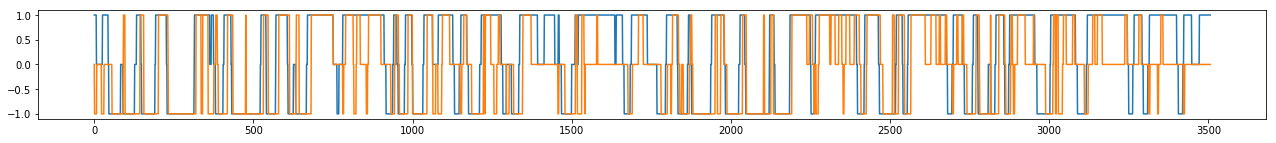

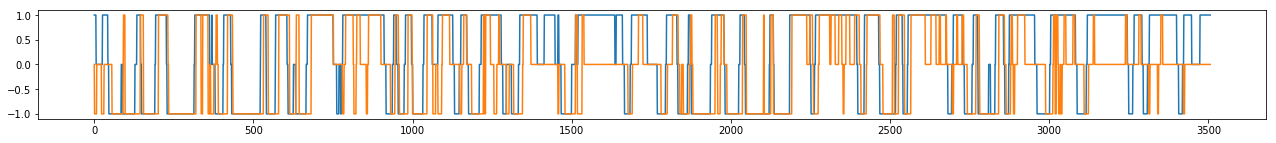

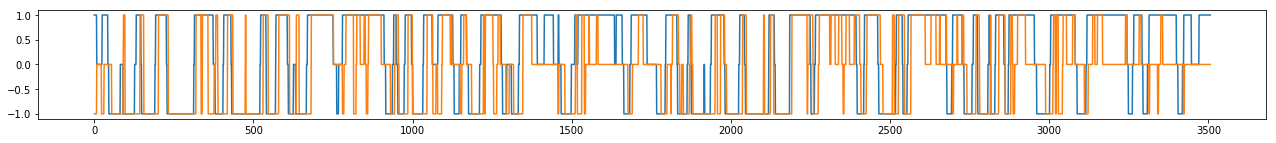

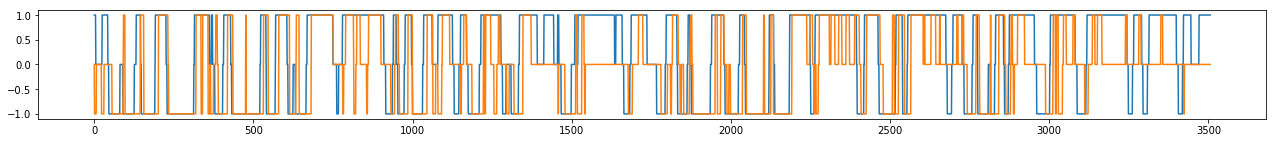

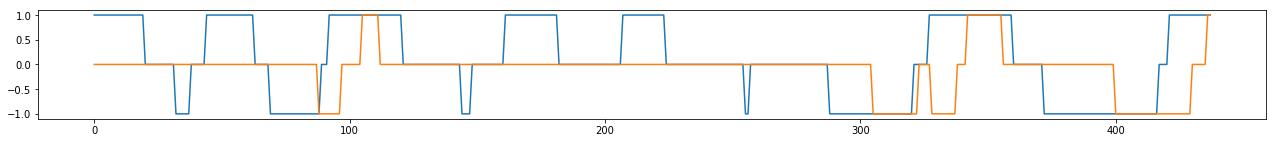

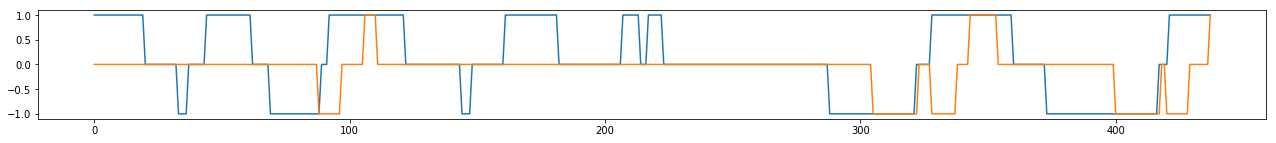

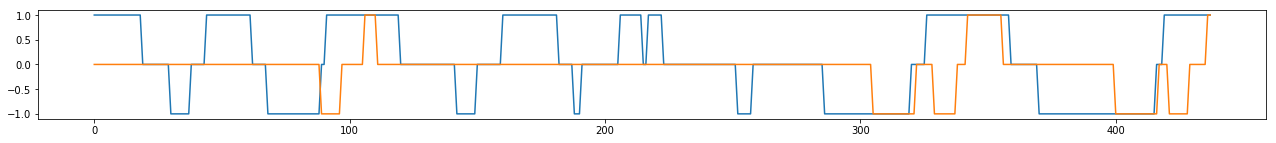

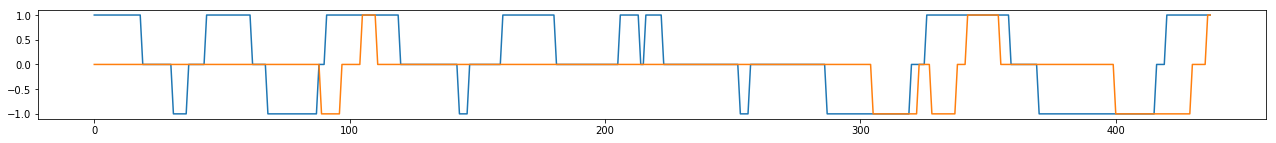

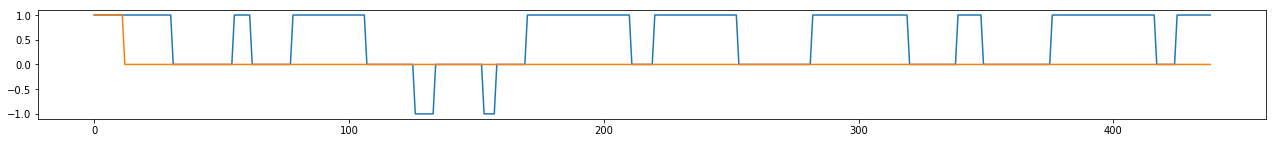

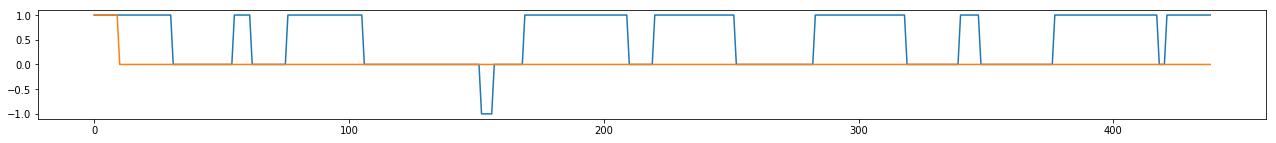

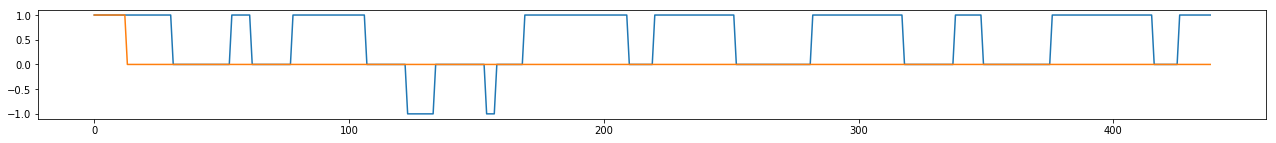

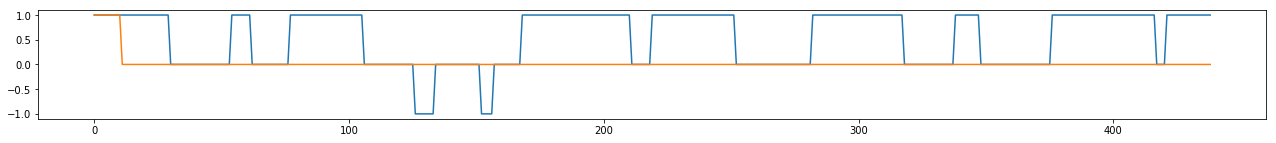

In [44]:
for which in ["train", "test", "valid"]:
    for i in range(4):
        which_output = i
        predicted = Indexer.predict_on_batch([train_data[which+'_df2']])
        predicted = predicted[which_output]
        correct = train_data[which+"_label"+str(which_output)]
        compare_output(predicted, correct)

In [ ]:
## dumped functions


def min_max_average(df, window_size=600):
    """
    use the min and max of the window_size days of data in df to normalize the window_size data.
    this method is running the risk of incorporating future data to the past, but we will see
    
    return the processed df and the start index
    """
    df = df.copy()
    
    for i in range(0, len(df), window_size):
        # find local min max
        dmax = df.iloc[i:i+window_size, :].max()
        dmin = df.iloc[i:i+window_size, :].min()
        
        # normalize data
        df.iloc[i:i+window_size, :] -= dmin
        df.iloc[i:i+window_size, :] /= dmax - dmin
        
    if len(df)%window_size >= window_size / 2:
        # deal with residuals
        # find local min max
        dmax = df.iloc[i-window_size:, :].max()
        dmin = df.iloc[i-window_size:, :].min()

        # normalize data
        df.iloc[i-window_size, :] -= dmin
        df.iloc[i-window_size, :] /= dmax - dmin
        
        return df, 0
    
    return df.iloc[:-(len(df)%window_size), :], 0

### Sigmoid normalization research

In [43]:
# read the factor time data
df = pd.read_csv("Dataset_1003.csv", index_col=[0])

# seperate S&P label out
target = df.iloc[:, :4]
df = df.iloc[:, 4:] # preserve them as the input data

# collect col index for daily updated factors and quarterly updated factors
rate = get_update_rate(df)
slow_index = [i for i, r in enumerate(rate) if r > 1 and i not in [df.columns.get_loc('Change in private inventories')]]
quick_index = [i for i, r in enumerate(rate) if r == 1 and i not in [df.columns.get_loc("__SIC1_D_High")]]

slow_df = df.iloc[:, slow_update_index]

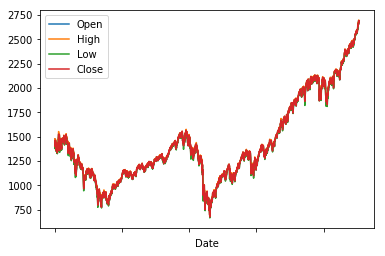

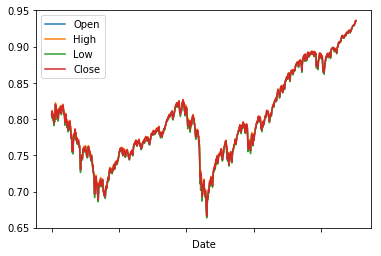

In [59]:
df.iloc[:, :4].plot()
target.plot()